## scikit-tda modules
* Kepler Mapper - mapper algorithm
* Ripser - persistence homology computations
* Persim - comparison and analysis of persistence diagrams
* CechMate - advanced and custom filterations
* TaDAsets - synthetic data sets of some manifolds (shapes, torus, swiss rolls)

## Outline of this notebook
1. In this notebook we focus on the persistence tools of **scikit-tda**: **ripser** and **persim**
2. We start with an overview of the API required to produce persistence diagrams.
3. Then we will take a look at some tools for analysing PDs available in **scikit-tda**.

In [80]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

## 1. Persistence API
At first, let's generate a toy example, `tadasets` has few functions to generate random point clouds of different shapes. Below we generate two samples of size `n = 100` from 1-sphere:
* `data-clean` - data is sampled directly from a unit circle.
* `data-noisy` - data is sampled from a unit circle with added standard normal noise scaled by `noise` parameter.

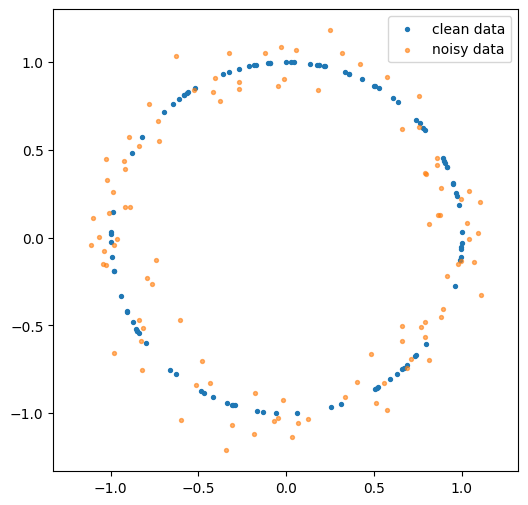

In [81]:
import tadasets
np.random.seed(565656)

data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
data_noisy = tadasets.dsphere(d=1, n=100, noise=0.10)

# data_clean = tadasets.infty_sign(n=100, noise=0.0)
# data_noisy = tadasets.infty_sign(n=100, noise=0.15)

plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(data_clean[:,0], data_clean[:,1], label='clean data', s=8)
plt.scatter(data_noisy[:,0], data_noisy[:,1], label='noisy data', s=8, alpha=0.6)
plt.axis('equal')
plt.legend()
plt.show()

### 1.1. Computing and plotting peristence diagrams for point cloud data
* To compute the PD of a point cloud we are using `ripser` module. Either directly or via an object of `Rips` class.
* To plot PDs we use `Persim` module.
* `ripser` can take a distance matrix as input.

#### 1.1.1. Out of the box peristence

In [82]:
import ripser
import persim

def diagram_sizes(dgms):
    return ", ".join([f'|$H_{i}$|={len(d)}' for i, d in enumerate(dgms)])

In [83]:
ripser.ripser(data_clean)

{'dgms': [array([[0.        , 0.00037095],
         [0.        , 0.00067418],
         [0.        , 0.00077133],
         [0.        , 0.00098735],
         [0.        , 0.00099303],
         [0.        , 0.00248709],
         [0.        , 0.00302659],
         [0.        , 0.00538296],
         [0.        , 0.00627622],
         [0.        , 0.00693182],
         [0.        , 0.00745432],
         [0.        , 0.00814083],
         [0.        , 0.00833747],
         [0.        , 0.00868411],
         [0.        , 0.00928664],
         [0.        , 0.00936573],
         [0.        , 0.00946265],
         [0.        , 0.01140243],
         [0.        , 0.01162059],
         [0.        , 0.01191397],
         [0.        , 0.01214934],
         [0.        , 0.01216638],
         [0.        , 0.01243924],
         [0.        , 0.01426252],
         [0.        , 0.0151691 ],
         [0.        , 0.01521807],
         [0.        , 0.01540211],
         [0.        , 0.0155305 ],
         [0.

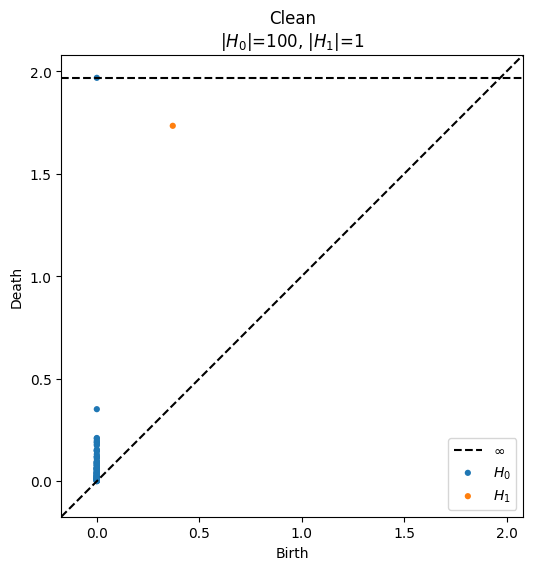

In [84]:
dgm_clean = ripser.ripser(data_clean)['dgms']
persim.plot_diagrams(dgm_clean, show=True, title=f'Clean\n{diagram_sizes(dgm_clean)}')

#### 1.1.2. Class interface
The **Ripser** module also provides a sklearn-style class `Rips`.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


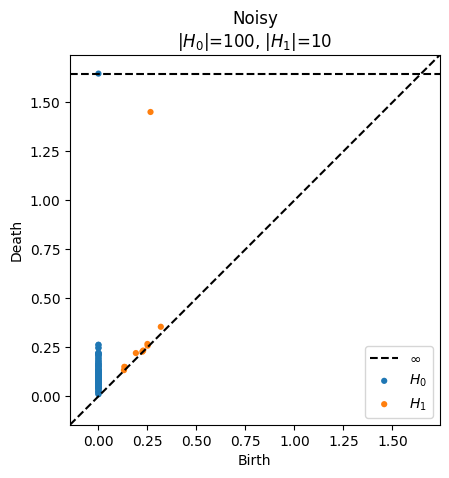

In [85]:
from ripser import Rips
rips = Rips()
dgm_noisy = rips.transform(data_noisy)
rips.plot(show=True, title=f'Noisy\n{diagram_sizes(dgm_noisy)}')

#### 1.1.3. Input option: Distance matrix
An important feature of `Ripser` is its ability to take distance matrices as input. This flexibility allows `Ripser` to handle n-dimensional point cloud as well as more abstract metric spaces, for example, given by graphs.

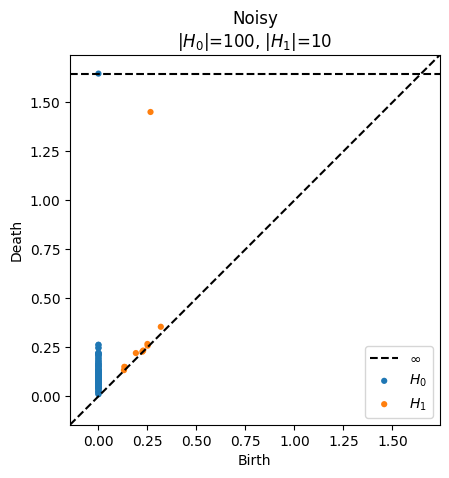

In [86]:
from sklearn.metrics.pairwise import pairwise_distances

D = pairwise_distances(data_noisy, metric='euclidean')

dgm_noisy = ripser.ripser(D, distance_matrix=True)['dgms']
persim.plot_diagrams(dgm_noisy, show=True, title=f'Noisy\n{diagram_sizes(dgm_noisy)}')

### 1.2. Ripser's options
* `maxdim`: `int` - maximum homology dimension computed
* `thresh`: `float` - maximum radius for Rips filteration
* `coeff`: `int` - field of coefficients of homology

#### 1.2.1. Maximum homology dimension
* 0 - points, $H_0$ &equiv; connected components
* 1 - line segments, $H_1$ &equiv; holes
* 2 - triangles, $H_2$ &equiv; cavaties

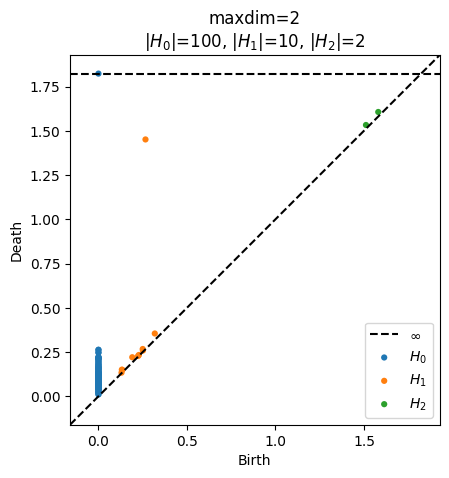

In [87]:
dgm_noisy = ripser.ripser(data_noisy, maxdim=2)['dgms']
persim.plot_diagrams(dgm_noisy, show=True, title=f'maxdim=2\n{diagram_sizes(dgm_noisy)}')

#### 1.2.2. Maximum Radius for Rips filteration
**Vitoris-Rips complex**, also called *Vietoris complex* or *Rips complex*, is a way  of forming a topological space from distances in a set of points. It is an abstract simplical complex that contains a simplex for every finit set of points that has diameter at most **R**:
* if a finit set **S** of *k* points has the property that the distance between every pair of points in **S** is at most **R**, then we include **S** as a *(k-1)*-simplex in the complex.

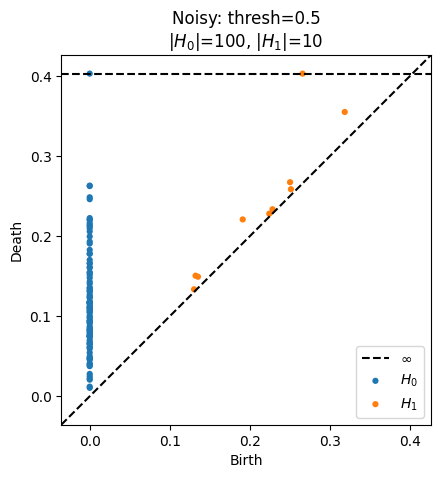

In [88]:
thresh = 0.5
dgm_noisy = ripser.ripser(data_noisy, thresh=thresh)['dgms']
persim.plot_diagrams(dgm_noisy, show=True, title=f'Noisy: thresh={thresh}\n{diagram_sizes(dgm_noisy)}')

C:\Users\Jason_Chesney\AppData\Local\Temp\ipykernel_20892\1132280155.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = cm.get_cmap('tab10')


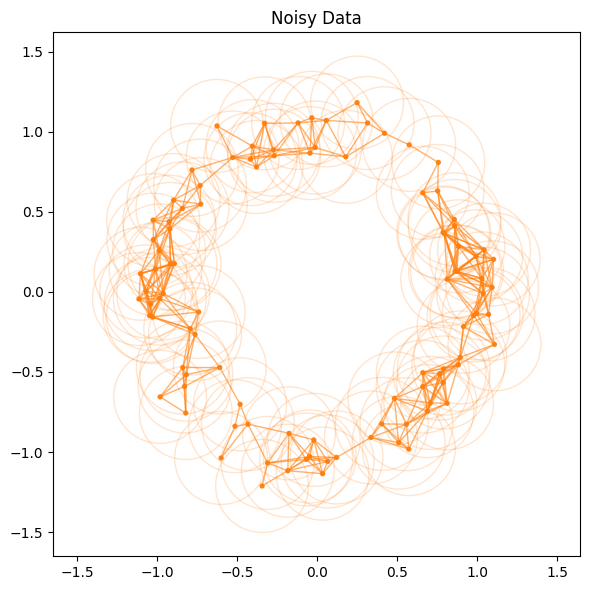

In [89]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

def plot_rips_complex(data, R, label='data', col=1, maxdim=2):
    tab10 = cm.get_cmap('tab10')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(label)
    ax.scatter(data[:,0], data[:,1], label=label, s=8, alpha=0.9, c=np.array(tab10([col] * len(data))))

    for xy in data:
        ax.add_patch(mpatches.Circle(xy, radius=R, fc='none', ec=tab10(col), alpha=0.2))

    for i, xy in enumerate(data):
        if maxdim >= 1:
            for j in range(i + 1, len(data)):
                pq = data[j]
                if (xy != pq).all() and (np.linalg.norm(xy - pq) <= R):
                    pts = np.array([xy, pq])
                    ax.plot(pts[:,0], pts[:,1], color=tab10(col), alpha=0.6, linewidth=1)
                if maxdim == 2:
                    for k in range(j + 1, len(data)):
                        ab = data[k]
                        if ((ab != pq).all() and (np.linalg.norm(xy - pq) <= R) and (np.linalg.norm(xy - ab) <= R) and (np.linalg.norm(pq - ab) <= R)):
                            pts = np.array([xy, pq, ab])
                            ax.fill(pts[:,0], pts[:,1], facecolor=tab10(col), alpha=0.1)
                        pass
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    pass

plot_rips_complex(data_noisy, R=0.29, label='Noisy Data', maxdim=1)

#### 1.2.3. Ripser's options for the class interface
When an object of the `Rips` class is used, the options are set as fields of the ripser object.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


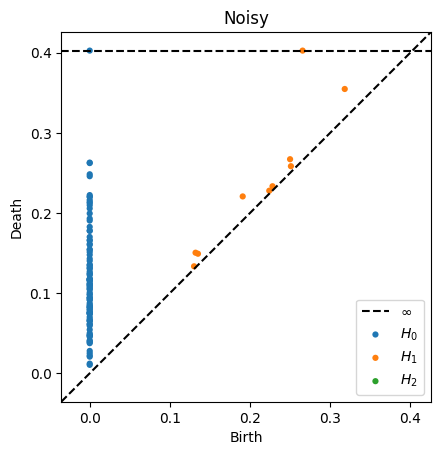

In [90]:
rips = Rips()
rips.maxdim = 2
rips.thresh = 0.5
rips.coef = 3
rips.transform(data_noisy)
rips.plot(show=True, title='Noisy')

### 1.3. Plotting options
* persistence diagrams of different data sets on one plot
* customizing the plot: `xy_range`, title: `str`, size: `str`
* `lifetime`
* persistence images

#### 1.3.1. PDs of different datasets on one plot

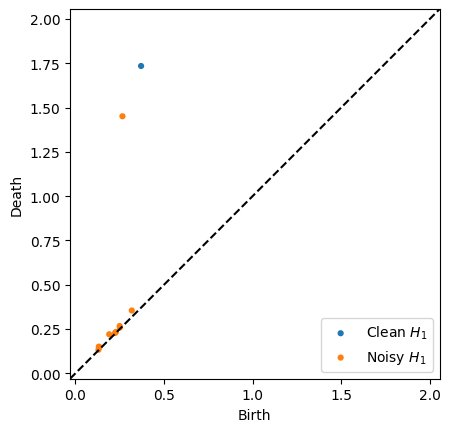

In [91]:
dgms_clean = ripser.ripser(data_clean)['dgms']
dgms_noisy = ripser.ripser(data_noisy, maxdim=2)['dgms']
persim.plot_diagrams([dgms_clean[1], dgms_noisy[1]], labels=['Clean $H_1$', 'Noisy $H_1$'], show=True)

#### 1.3.2. Customizing plot

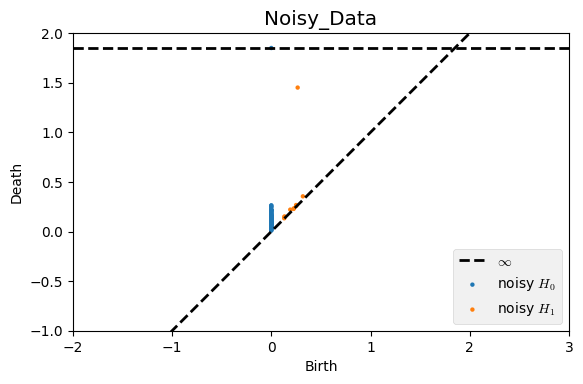

In [92]:
persim.plot_diagrams(dgms_noisy, title='Noisy_Data', labels=['noisy $H_0$', 'noisy $H_1$'], colormap='bmh', xy_range=[-2, 3, -1, 2], size=10, diagonal=True, show=True) 

#### 1.3.3. Lifetime plots
horizontal diagrams

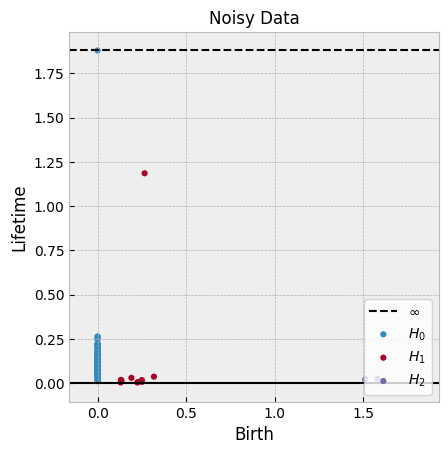

In [93]:
persim.plot_diagrams(dgms_noisy, title='Noisy Data', lifetime=True, show=True)

#### 1.3.4. Persistence images
The *Persim* module contains class `PersistenceImager` that is a transformer which converts persistence diagrams into persistence images.

<Axes: title={'center': 'Persistence Image'}, xlabel='birth', ylabel='persistence'>

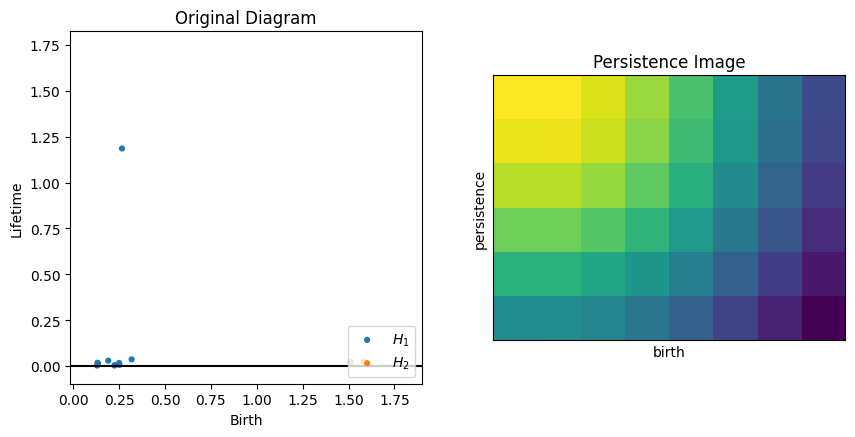

In [94]:
from persim import PersistenceImager

pimager = PersistenceImager(pixel_size=0.2)

# The `fit()` can be called on one or more (*, 2) numpy arrays
# to automatically determine the minimum birth and persistence ranges needed to capture all persistence pairs.
# the ranges and resolutions are automatically adjusted to accomodate the specified pixel size.
pimager.fit(dgms_noisy[1:3])

# The `transform()` method can then be called on one or more (*,2) numpy arrays
# to generate persistence images from diagrams.
imgs = pimager.transform(dgms_noisy[1:3])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original Diagram')
persim.plot_diagrams(dgms_noisy[1:3], lifetime=True, ax=axs[0], labels=['$H_1$', '$H_2$'])

axs[1].set_title('Persistence Image')
pimager.plot_image(imgs[0], ax=axs[1])

## 2. Analysis of PDs

### 2.1. Distance between diagrams
**persim** package contains implementations of a number of distance functions between persistence diagrams:
* Wasserstein distance with matching between persistence diagrams.
* *Bottleneck* distance with matching between persistence diagrams.
* Estimation of Gromov-Hausdroff distance.
* The pseudo-metric between two diagrams based on the continuous heat kernel.

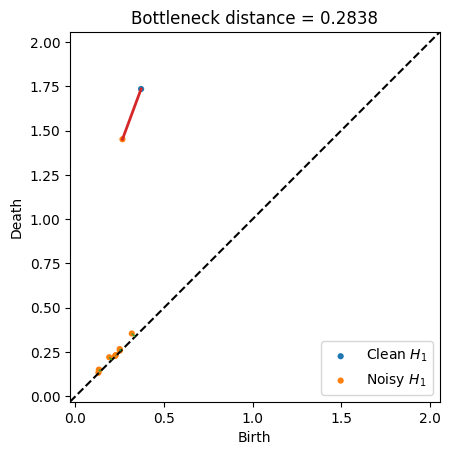

In [95]:
dgm_clean = ripser.ripser(data_clean)['dgms'][1]
dgm_noisy = ripser.ripser(data_noisy)['dgms'][1]

# The bottelneck of the matching is shown as a red line,
# While the other pairs in the perfect matching which are less than the diagonal, are shown as green lines
# (NOTE: There may be many possible matchings with the minimum bottleneck, and this returns an arbitrary one)
distance_bottleneck, matching = persim.bottleneck(dgm_clean, dgm_noisy, matching=True)
persim.bottleneck_matching(dgm_clean, dgm_noisy, matching, labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.title(f'Bottleneck distance = {distance_bottleneck:0.4f}', )
plt.show()

### 2.2. Persistence Images in Classification
* We construct datasets from two classes, one just *noise* and the other *noise* with *circles* in the middle.
* We then compute persistence diagrams with ripser.
* In order to apply ML algorithms, we need to vectorize computed PDs. We do this by converting them into persistence images with **Persim**.
* Using these persistence images, we build a Logistic Regression model using a LASSO penalty to classify whether the dataset has a circle or not.


#### 2.2.1. Data
We start by generating *M* point clouds each of size *N* : half of them are noise, another half are noise with circles.

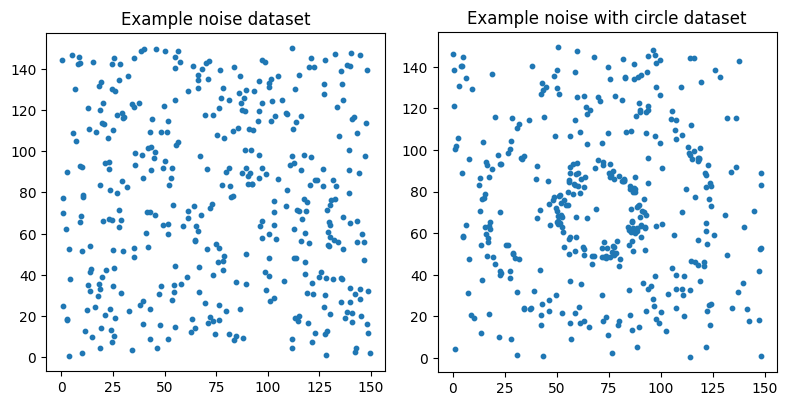

In [96]:
np.random.seed(565656)
M = 50          # total number of samples
m = int(M / 2)    # number of samples per class ('noise'/'circles')
N = 400         # number of points per dataset

def noise(N, scale):
    return scale * np.random.random((N, 2))

def circle(N, scale, offset):
    '''Generates two circles with center at `offset` scaled by `scale`'''
    half = int(N / 2)
    circ = np.concatenate((tadasets.dsphere(d=1, n=half, r=1.1, noise=0.05), tadasets.dsphere(d=1, n=N-half, r=0.4, noise=0.05)))
    return offset + scale * circ

# Generate data
just_noise = [noise(N, 150) for _ in range(m)]

half = int(N / 2)
with_circle = [np.concatenate((circle(half, 50, 70), noise(N - half, 150))) for _ in range(m)]

datas = []
datas.extend(just_noise)
datas.extend(with_circle)

# Define labels
labels = np.zeros(M)
labels[m:] = 1

# Visualize the data
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

xs, ys = just_noise[0][:,0], just_noise[0][:,1]
axs[0].scatter(xs, ys, s=10)
axs[0].set_title('Example noise dataset')
axs[0].set_aspect('equal', 'box')

xs, ys = with_circle[0][:,0], with_circle[0][:,1]
axs[1].scatter(xs, ys, s=10)
axs[1].set_title('Example noise with circle dataset')
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

#### 2.2.2. Persistence Diagrams
For each point cloud we generate a $H_1$ peristence diagram.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


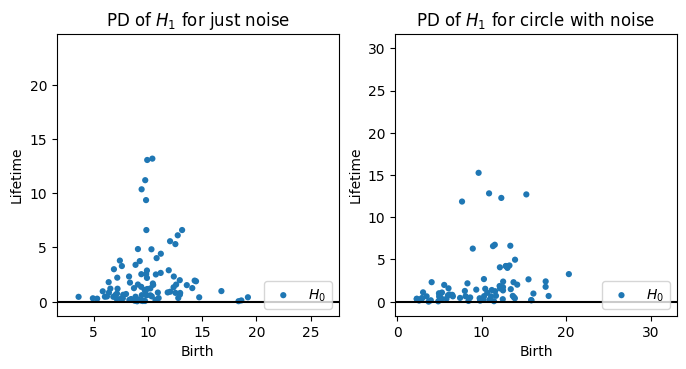

In [97]:
rips = ripser.Rips(maxdim=1, coeff=2)
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]

plt.figure(figsize=(8,4))

plt.subplot(121)
rips.plot(diagrams_h1[0], show=False, lifetime=True)
plt.title('PD of $H_1$ for just noise')

plt.subplot(122)
rips.plot(diagrams_h1[-1], show=False, lifetime=True)
plt.title('PD of $H_1$ for circle with noise')

plt.show()

#### 2.2.3. Persistence Images
Next, each persistence diagram is turned into a persistence image, which is just a 2d-array of pixels.

PI Resolution = (33, 23)


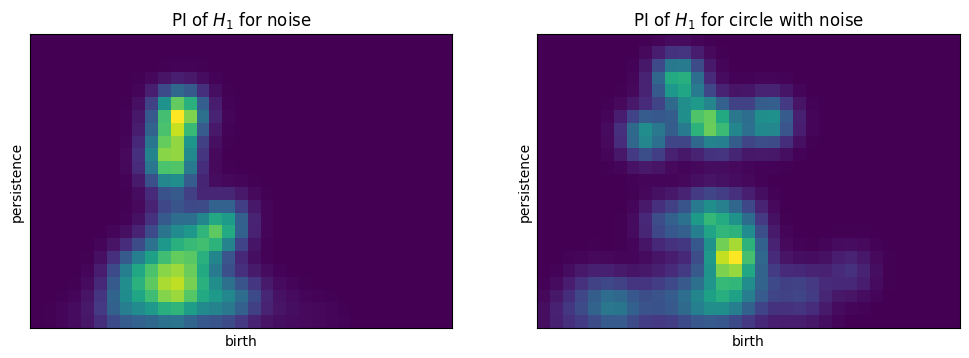

In [98]:
pimagr = PersistenceImager(pixel_size=0.8)
pimagr.fit(diagrams_h1)
imgs = pimagr.transform(diagrams_h1)
print(f'PI Resolution = {pimagr.resolution}')

plt.figure(figsize=(12, 7))
ax = plt.subplot(121)
pimagr.plot_image(imgs[0], ax)
plt.title('PI of $H_1$ for noise')

ax = plt.subplot(122)
pimagr.plot_image(imgs[-1], ax)
plt.title('PI of $H_1$ for circle with noise')
plt.show()

#### 2.2.4. Classification
Now, we flatten 2d-images into 1d-arrays and randomly split them into testing and training data sets.

Finally, we fit Logistic Regression with a LASSO penelty to the training data, and compute mean accuracy on the test data.

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# train/test data
imgs_array = np.array([img.flatten() for img in imgs])
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.4, random_state=42)
print(f'Train size = {X_train.shape[0]}\nTest size = {X_test.shape[0]}\nDimensions = {imgs_array.shape[1]}')

# logistic regrssion
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f"{'-'*36}\nTrain score = {train_score}, Test score = {test_score}") 

Train size = 30
Test size = 20
Dimensions = 759
------------------------------------
Train score = 1.0, Test score = 0.85
